In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
su_df = pd.read_csv('50_Startups.csv')
display(su_df.head())
display(su_df.info())

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


None

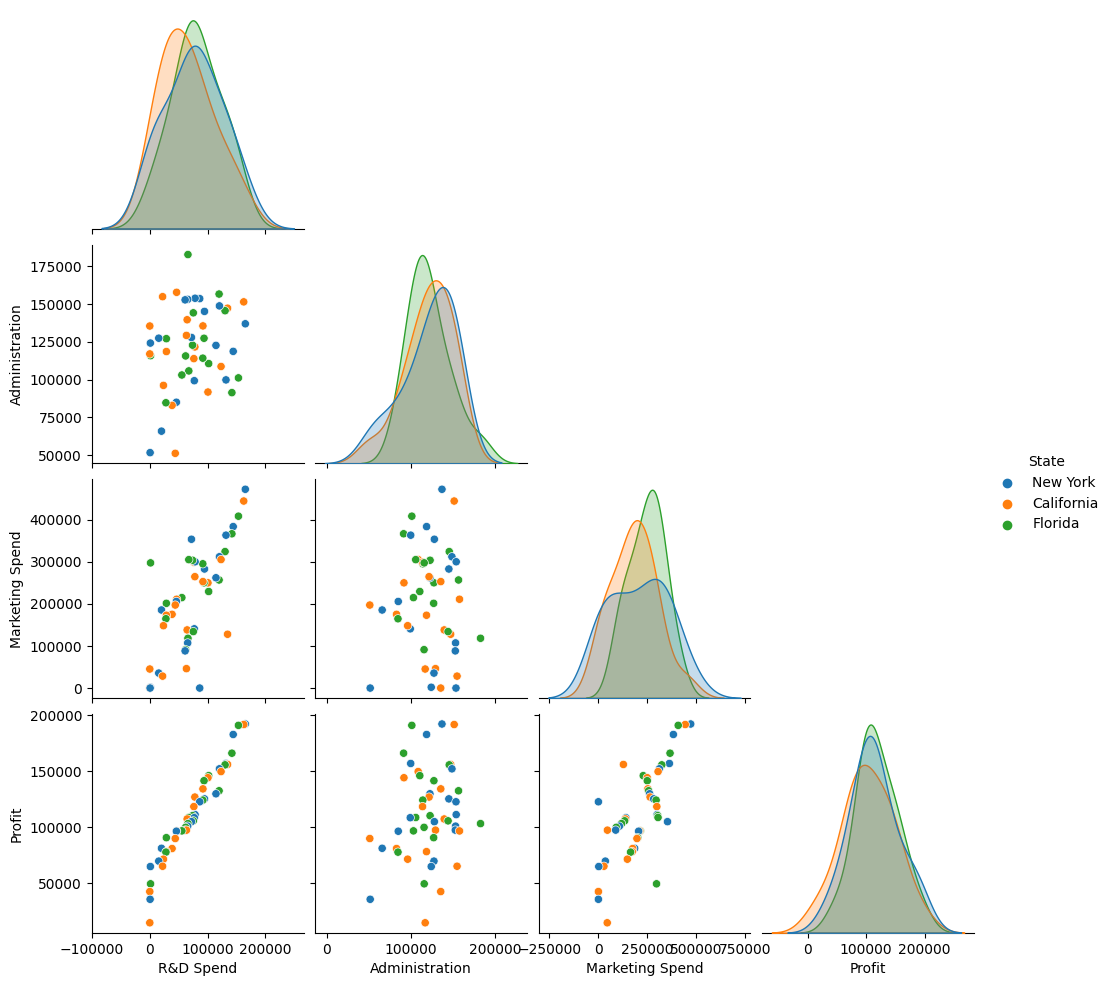

In [ ]:
sns.pairplot(su_df, corner = True, hue = 'State')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select independent variables
X_categorical = su_df['State'].values.reshape(-1,1)

# Set the encoder
enc_X = OneHotEncoder()

# Apply the encoder
enc_X.fit(X_categorical)


OneHotEncoder()

In [ ]:
# Get the encoded variables
X_cat_enc = enc_X.transform(X_categorical).toarray()

# Select only the first two encoded variables. Question: why?
X_cat_enc[:,:2]

# Finally join the dataset (we'll use this code snippet later.)
X = np.concatenate((X_continuos, X_cat_enc), axis = 1)

# Get the depedent variable
y = su_df['Profit'].values.reshape(-1,1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train and test set
X_train_cont, X_test_cont, X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_continuos, X_cat_enc, y, test_size = 0.2, random_state = 2112)

# Preprocessing: scaling
scaler_X_cont = StandardScaler()
scaler_X_cont.fit(X_train_cont)
X_train_cont_scaled = scaler_X_cont.transform(X_train_cont)
X_test_cont_scaled = scaler_X_cont.transform(X_test_cont)

# Join datasets
X_train = np.concatenate((X_train_cont_scaled, X_train_enc), axis = 1)
X_test = np.concatenate((X_test_cont_scaled, X_test_enc), axis=1)

# Scale depedent variable.
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Linear regression methods

## Ordinary Least Square

Objective function:

$\hat{y}(x,w) = ||X w - y||^2_2 $

Where:

$||\cdot||_2$ is the sum of the squares of the component of the argument vector

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
print("Score:", reg.score(X_test, y_test))
print("Coefficients")
print(reg.coef_)

Score: 0.9604236821915405
Coefficients
[[35161.115772   -1529.44995969  1760.82042733 -1013.24286351
   -349.40213232  1362.64499583]]


## Ridge
.. if you need to tame the weights.

Objective function:

$\hat{y}(x,w) = ||X w - y||^2_2 + \alpha ||w||^2_2$

$\alpha$ is a hyperparameter and its role is to tune the regularization $||w||^2_2$ which controls the coefficients of the regression.

In [ ]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha=.5)

reg.fit(X_train, y_train)

Ridge(alpha=0.5)

In [ ]:
print("Score:", reg.score(X_test, y_test))
print("Coefficients")
print(reg.coef_)

Score: 0.9615847101143797
Coefficients
[[34120.84273785 -1170.09528585  2469.00933465  -957.47726751
   -514.57821867  1472.05548618]]


## Lasso
This method "prefers" models with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent.

Objective function:

$\hat{y}(x,w) = \frac{1}{2 n_{samples}}||X w - y||^2_2 + \alpha ||w||_1$

Where:
$||\cdot||_1$ is the sum of the absolute values of the component of the argument vector

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/L1_and_L2_balls.svg/1280px-L1_and_L2_balls.svg.png'>

In [ ]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha = 0.1)
reg.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:
print("Score:", reg.score(X_test, y_test))
print("Coefficients")
print(reg.coef_)

Score: 0.9604239404883763
Coefficients
[35161.54241386 -1529.47761954  1760.40145554 -1827.95296156
 -1163.95694679   547.44154947]


### Looking for the best coefficient: LASSO
We can look for the best score by searching all the possible value of the hyperparameter alpha via the CV method.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create a Lasso regression model
lasso = Lasso()

# Define the alpha values to search
param_grid = {'alpha': np.logspace(3,4, num = 100)}

# Create a GridSearchCV object to find the best alpha
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print("Best Alpha:", best_alpha)

# The best model is available as grid_search.best_estimator_
best_model = grid_search.best_estimator_

Best Alpha: 1707.3526474706905


In [ ]:
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
results_df.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.000684,0.000020,0.000359,0.000015,1707.352647,{'alpha': 1707.3526474706905},0.973656,0.911595,0.862832,0.856590,0.978579,0.916650,0.052180,1
22,0.000768,0.000111,0.000382,0.000022,1668.100537,{'alpha': 1668.100537200059},0.973985,0.911208,0.862270,0.857053,0.978600,0.916623,0.052276,2
24,0.000665,0.000014,0.000367,0.000010,1747.5284,{'alpha': 1747.5284000076829},0.973314,0.911687,0.863402,0.856110,0.978554,0.916613,0.052092,3
25,0.000619,0.000129,0.000338,0.000070,1788.649529,{'alpha': 1788.649529057435},0.972960,0.911789,0.863981,0.855614,0.978524,0.916574,0.052004,4
21,0.000453,0.000013,0.000261,0.000014,1629.750835,{'alpha': 1629.7508346206434},0.974303,0.910684,0.861718,0.857504,0.978617,0.916565,0.052374,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000608,0.000105,0.000339,0.000042,9111.627561,{'alpha': 9111.627561154895},0.884568,0.910088,0.880576,0.739905,0.907624,0.864552,0.063440,96
96,0.000541,0.000133,0.000267,0.000047,9326.033469,{'alpha': 9326.0334688322},0.880831,0.908913,0.878790,0.735126,0.903425,0.861417,0.064263,97
97,0.000453,0.000064,0.000303,0.000090,9545.484567,{'alpha': 9545.484566618346},0.876933,0.907637,0.876892,0.730151,0.899004,0.858123,0.065124,98
98,0.000412,0.000008,0.000246,0.000010,9770.099573,{'alpha': 9770.099572992256},0.872869,0.906254,0.874876,0.724974,0.894349,0.854664,0.066024,99


In [ ]:
best_model = grid_search.best_estimator_

print("Score:", best_model.score(X_test, y_test))
print("Coefficients")
print(best_model.coef_)


Score: 0.9583518017811968
Coefficients
[33434.8269298     -0.          1252.77070946    -0.
    -0.             0.        ]


Question: which features haven't we used in the model?
Excercise: evaluate the best value of alpha if the dependent variable is scaled.
Does it change? Try to explain why. (Hit: check the coefficients of the regression).

## ElasticNet: the best of both the worlds

Objective function:

$\hat{y}(x,w) = \frac{1}{2 n_{samples}}||X w - y||^2_2 + \alpha \rho ||w||_1 + \alpha \frac{1-\rho}{2}||w||^2_2$

$\rho$ tunes the weight of the $||\cdot||_2$ regularization addend in the function.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create a Lasso regression model
lasso = ElasticNet()

# Define the alpha values to search
param_grid = {'alpha': np.logspace(-2,1, num = 50), 'l1_ratio': np.linspace(0.05,0.95,21)}

# Create a GridSearchCV object to find the best alpha
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train_scaled)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
best_rho = grid_search.best_params_['l1_ratio']
print("Best Alpha:", best_alpha)
print("Best Rho:", best_rho)

# The best model is available as grid_search.best_estimator_
best_model = grid_search.best_estimator_

Best Alpha: 0.04714866363457394
Best Rho: 0.95


In [ ]:
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
results_df.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
251,0.000561,0.000011,0.000331,0.000022,0.047149,0.95,"{'alpha': 0.04714866363457394, 'l1_ratio': 0.95}",0.973914,0.912646,0.859937,0.856735,0.978364,0.916319,0.052744,1
230,0.000669,0.000028,0.000356,0.000017,0.040949,0.95,"{'alpha': 0.040949150623804255, 'l1_ratio': 0.95}",0.975690,0.909488,0.856999,0.859324,0.978484,0.915997,0.053297,2
272,0.000631,0.000076,0.000630,0.000545,0.054287,0.95,"{'alpha': 0.054286754393238594, 'l1_ratio': 0.95}",0.971711,0.913384,0.863173,0.853611,0.978075,0.915991,0.052243,3
250,0.000564,0.000013,0.000325,0.000015,0.047149,0.905,"{'alpha': 0.04714866363457394, 'l1_ratio': 0.905}",0.974458,0.913167,0.856691,0.857337,0.978184,0.915968,0.053387,4
271,0.000561,0.000007,0.000324,0.000016,0.054287,0.905,"{'alpha': 0.054286754393238594, 'l1_ratio': 0....",0.972390,0.914349,0.859528,0.854334,0.977869,0.915694,0.052918,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,0.000416,0.000012,0.000246,0.000011,3.727594,0.905,"{'alpha': 3.727593720314938, 'l1_ratio': 0.905}",-0.137125,-0.015370,-0.195531,-0.168972,-0.013159,-0.106031,0.077179,847
902,0.000411,0.000008,0.000253,0.000018,3.727594,0.95,"{'alpha': 3.727593720314938, 'l1_ratio': 0.95}",-0.137125,-0.015370,-0.195531,-0.168972,-0.013159,-0.106031,0.077179,847
734,0.000818,0.000152,0.000434,0.000068,1.206793,0.95,"{'alpha': 1.2067926406393288, 'l1_ratio': 0.95}",-0.137125,-0.015370,-0.195531,-0.168972,-0.013159,-0.106031,0.077179,847
892,0.000453,0.000045,0.000243,0.000009,3.727594,0.5,"{'alpha': 3.727593720314938, 'l1_ratio': 0.499...",-0.137125,-0.015370,-0.195531,-0.168972,-0.013159,-0.106031,0.077179,847


In [ ]:
best_model = grid_search.best_estimator_

print("Score:", best_model.score(X_test, y_test_scaled))
print("Coefficients")
print(best_model.coef_)


Score: 0.958643956379202
Coefficients
[ 0.89648052 -0.          0.03707365 -0.         -0.          0.        ]
